In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

In [64]:
train = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Train.csv')
test = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Test.csv')
health_camp = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Health_Camp_Detail.csv')
camp_1 = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\First_Health_Camp_Attended.csv')
camp_2 = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Second_Health_Camp_Attended.csv')
camp_3 = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Third_Health_Camp_Attended.csv')
patient_profile = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Patient_Profile.csv')
ss = pd.read_csv('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\sample_submmission.csv')
data_dict = pd.read_excel('F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\Train_2\Train\Data_Dictionary.xlsx')


In [65]:
np.intersect1d(train['Patient_ID'], test['Patient_ID']).shape[0]/train['Patient_ID'].nunique()

0.28362612310580665

In [66]:
patient_profile[['Income', 'Education_Score', 'Age']] = patient_profile[['Income', 'Education_Score', 'Age']].apply(lambda x: x.str.replace('None', 'NaN').astype('float'))
patient_profile[['City_Type','Employer_Category']] = patient_profile[['City_Type','Employer_Category']].apply(lambda x: pd.factorize(x)[0])

In [67]:
train.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
       'Var3', 'Var4', 'Var5'],
      dtype='object')

In [68]:
for df_tmp in [train, test]:
    for c in ['Health_Camp_ID']:
        # mapper = train
        df_tmp[c + '_freq'] = df_tmp[c].map(df_tmp[c].value_counts(normalize=True))

In [69]:
test['Patient_ID'].describe()

count     35249.000000
mean     507020.926863
std       12478.669016
min      485678.000000
25%      496203.000000
50%      507018.000000
75%      517869.000000
max      528657.000000
Name: Patient_ID, dtype: float64

In [70]:
train = pd.merge(train, patient_profile, on = 'Patient_ID', how = 'left')
test = pd.merge(test, patient_profile, on = 'Patient_ID', how = 'left')

In [71]:
train.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
       'Var3', 'Var4', 'Var5', 'Health_Camp_ID_freq', 'Online_Follower',
       'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income',
       'Education_Score', 'Age', 'First_Interaction', 'City_Type',
       'Employer_Category'],
      dtype='object')

In [72]:
for c in [camp_1, camp_2, camp_3, train]:
    c['id'] = c['Patient_ID'].astype('str') + c['Health_Camp_ID'].astype('str')
camp_3 = camp_3[camp_3['Number_of_stall_visited'] > 0]

all_patients_in_camp = pd.Series(camp_1['id'].tolist() + camp_2['id'].tolist() + camp_3['id'].tolist()).unique()

train['target'] = 0
train.loc[train['id'].isin(all_patients_in_camp), 'target'] = 1

In [73]:
train['target'].value_counts(normalize=True)

0    0.727224
1    0.272776
Name: target, dtype: float64

In [74]:
health_camp['Category1'] = health_camp['Category1'].map({'First': 1, 'Second': 2, 'Third': 3})
health_camp['Category2'] = pd.factorize(health_camp['Category2'])[0]

health_camp['Camp_Start_Date'] = pd.to_datetime(health_camp['Camp_Start_Date'])
health_camp['Camp_End_Date'] = pd.to_datetime(health_camp['Camp_End_Date'])
health_camp['total_days_of_campaign'] = (health_camp['Camp_End_Date'] - health_camp['Camp_Start_Date']).dt.days

In [75]:
train = pd.merge(train, health_camp, on = 'Health_Camp_ID', how = 'left')
test = pd.merge(test, health_camp, on = 'Health_Camp_ID', how = 'left')

In [76]:
train.isnull().sum()

Patient_ID                    0
Health_Camp_ID                0
Registration_Date           334
Var1                          0
Var2                          0
Var3                          0
Var4                          0
Var5                          0
Health_Camp_ID_freq           0
Online_Follower               0
LinkedIn_Shared               0
Twitter_Shared                0
Facebook_Shared               0
Income                    53546
Education_Score           65345
Age                       51612
First_Interaction             0
City_Type                     0
Employer_Category             0
id                            0
target                        0
Camp_Start_Date               0
Camp_End_Date                 0
Category1                     0
Category2                     0
Category3                     0
total_days_of_campaign        0
dtype: int64

In [79]:
D_COL = 'Registration_Date'
for df_tmp in [train, test]:
    df_tmp[D_COL] = pd.to_datetime(df_tmp[D_COL])
test_min_date = test[D_COL].min()

In [80]:
train['Income']=train['Income'].fillna(train['Income'].median())

In [81]:
train['Age']=train['Age'].fillna(train['Age'].median())

In [82]:
test['Income']=test['Income'].fillna(test['Income'].median())

In [83]:
test['Age']=test['Age'].fillna(test['Age'].median())

In [154]:
## Getting a train and validation split, similar to test data

trn = train[train[D_COL] < test_min_date]
val = train[train[D_COL] >= test_min_date]

In [155]:
TARGET_COL = 'target'
features = [c for c in trn.columns if c not in ['Health_Camp_ID', 'Registration_Date', TARGET_COL, 'id', 'Camp_Start_Date', 'Camp_End_Date', 'First_Interaction']]
len(features)

6

In [99]:
test[features].isnull().sum()

Patient_ID                0
Var1                      0
Var2                      0
Var3                      0
Var4                      0
Var5                      0
Online_Follower           0
LinkedIn_Shared           0
Twitter_Shared            0
Facebook_Shared           0
Income                    0
Age                       0
City_Type                 0
Employer_Category         0
Category1                 0
Category2                 0
total_days_of_campaign    0
dtype: int64

In [100]:
#get correlations of each features in dataset
corrmat = train.corr()
print(corrmat['target'].sort_values(ascending = False),'\n')

target                    1.000000
Category1                 0.457572
Category2                 0.377779
City_Type                 0.085964
Var5                      0.064855
LinkedIn_Shared           0.053400
Employer_Category         0.050411
Online_Follower           0.048274
Var1                      0.045587
Twitter_Shared            0.044065
Facebook_Shared           0.037765
Var2                      0.033085
Var4                      0.032514
Age                       0.028055
Income                    0.024789
Var3                      0.013815
Patient_ID               -0.009431
total_days_of_campaign   -0.023285
Health_Camp_ID           -0.152114
Name: target, dtype: float64 



In [101]:
train = train.drop(["Category3","Education_Score"],axis = 1)

KeyError: "['Category3' 'Education_Score'] not found in axis"

In [152]:
train = train.drop(["Employer_Category","Income"],axis = 1)

In [129]:
train = train.drop(["LinkedIn_Shared","Online_Follower","Twitter_Shared","Facebook_Shared"],axis = 1)

In [153]:
test = test.drop(["Employer_Category","Income"],axis = 1)

In [130]:
test = test.drop(["LinkedIn_Shared","Online_Follower","Twitter_Shared","Facebook_Shared"],axis = 1)

In [78]:
test = test.drop(["Category3","Education_Score"],axis = 1)

In [26]:
clf = LGBMClassifier(n_estimators=550, learning_rate=0.05, random_state=1, colsample_bytree=0.5, reg_alpha=0, reg_lambda=0)

clf.fit(trn[features], trn[TARGET_COL], eval_set=[(val[features], val[TARGET_COL])], verbose=50,
        eval_metric = 'auc', early_stopping_rounds = 100)

preds = clf.predict_proba(test[features])[:, 1]

NameError: name 'LGBMClassifier' is not defined

# Random  Classifier


In [156]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer

In [157]:
#model for tuning the min samples of leaf
clf_1 = RandomForestClassifier(max_depth = 8, random_state=9)
clf_1.fit(trn[features], trn[TARGET_COL])

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [158]:
# predicting for min_samples 0f leaf as 2.
y_clf_1 = clf_1.predict_proba(test[features])[:, 1]

In [159]:
ss['Outcome'] = y_clf_1

ss.to_csv(r"F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\pip_prediction_results_HP.csv", index=False)

In [160]:
ss.head()

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.652799
1,500633,6584,0.378083
2,506945,6582,0.087519
3,497447,6551,0.440604
4,496446,6533,0.082514


# Feature Selection

In [150]:
from sklearn.feature_selection import RFE #importing RFE class from sklearn library

rfe = RFE(estimator= clf_1 , step = 1) 
# estimator clf_lr is the baseline model (basic model) that we have created under "Base line Model" selection
# step = 1: removes one feature at a time and then builds a model on the remaining features
# It uses the model accuracy to identify which features (and combination of features) contribute the most to predicting the target variable.
# we can even provide no. of features as an argument 

# Fit the function for ranking the features
fit = rfe.fit(trn[features], trn[TARGET_COL])

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 4
Selected Features: [False False  True False False  True  True  True]
Feature Ranking: [3 5 1 2 4 1 1 1]


In [151]:
selected_rfe_features = pd.DataFrame({'Feature':list(trn[features].columns),
                                      'Ranking':rfe.ranking_})
selected_rfe_features.sort_values(by='Ranking')

,Feature,Ranking
2,Age,1
5,Category1,1
6,Category2,1
7,total_days_of_campaign,1
3,City_Type,2
0,Var1,3
4,Employer_Category,4
1,Income,5


In [124]:
x =trn[features]
y =trn[TARGET_COL]

In [125]:
test = test[features]

In [477]:
x.columns

Index(['Patient_ID', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5',
       'Health_Camp_ID_freq', 'Online_Follower', 'LinkedIn_Shared',
       'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age',
       'City_Type', 'Employer_Category', 'Category1', 'Category2', 'Category3',
       'total_days_of_campaign'],
      dtype='object')

In [480]:
#model for tuning the min samples of leaf
clf_1 = RandomForestClassifier(min_samples_leaf=8, random_state=9)
clf_1.fit(x,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=9, verbose=0,
                       warm_start=False)

In [481]:
# predicting for min_samples 0f leaf as 2.
y_clf_2 = clf_1.predict_proba(test)[:, 1]

In [482]:
ss['Outcome'] = y_clf_2

ss.to_csv(r"F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\prediction_results_HP.csv", index=False)

# XGBoost

Feature Importances :  [0.02086491 0.02123422 0.01683851 0.02523087 0.01595323 0.02514695
 0.02249585 0.02126864 0.02727847 0.02508748 0.02804834 0.03380701
 0.6302326  0.03823144 0.04828157]


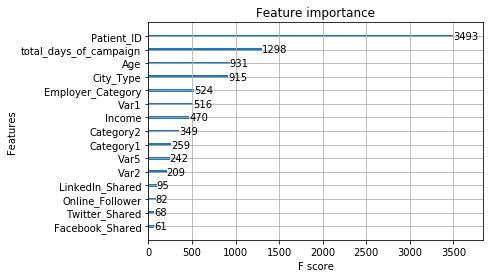

In [126]:
from xgboost import XGBClassifier
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBClassifier(max_depth = 8, random_state=9 )
xgb_model.fit(x, y)

print("Feature Importances : ", xgb_model.feature_importances_)

# plot feature importance
plot_importance(xgb_model)
plt.show()

In [127]:
y_pred_2 = xgb_model.predict_proba(test)[:, 1]

In [128]:
ss['Outcome'] = y_pred_2

ss.to_csv(r"F:\StudyIMT\Insightx\Competitions\Healthcare Analytics\prediction_results_HP.csv", index=False)